<font color="Green"><h1> **Intro to Deep Learning Mini Project 3 - GANs**</h1></font>
<font color="Green"><h2> **Github Link**</h2></font>
<p><a href = "https://github.com/Connor-Crosslin/Monet-GAN">Github Link</a></p>

In [1]:
#import necessary libraries

import pandas as pd
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras import layers
from keras import ops
import os
from os import listdir
from zipfile import ZipFile
import shutil
from PIL import Image

2024-06-16 20:52:18.272212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 20:52:18.272275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 20:52:18.274039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<font color="Green"><h2> **Problem Statement**</h2></font>
<p>
Given a set of images of Monet paintings, train a GAN comprised of two sub-networks, one to generate images in the style of Monet, and one to distinguish whether or not a given image is or is not in the style of Monet.
</p>

<font color="Green"><h2> **Exploratory Data Analysis and Preprocessing**</h2></font>
<p>

In [2]:
#get raw images

paintings_directory = "/kaggle/input/gan-getting-started/monet_jpg/"
photos_directory = "/kaggle/input/gan-getting-started/photo_jpg/"

num_paintings = len(listdir(paintings_directory))
print("There are ", num_paintings, "paintings")
num_photos = len(listdir(photos_directory))
print("There are ", num_photos, "photos")

There are  300 paintings
There are  7038 photos


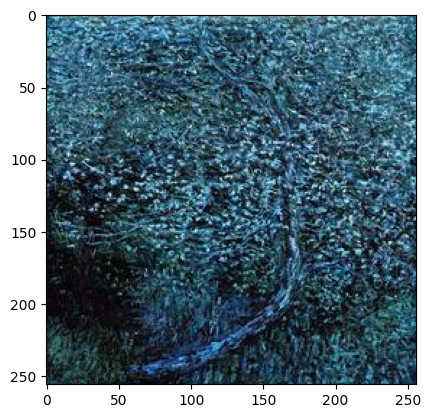

In [3]:
#rerun this cell to see random paintings

rand1 = random.randint(0, num_paintings-1)
rand_painting = cv2.imread(paintings_directory + listdir(paintings_directory)[rand1])
plt.imshow(rand_painting)
plt.show()

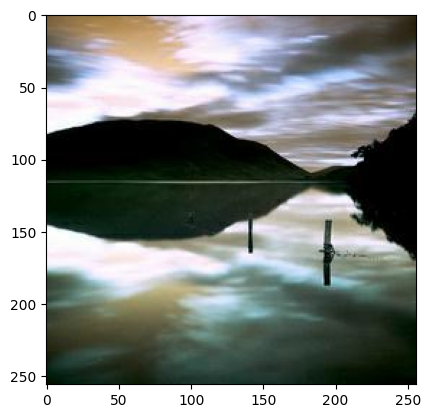

In [4]:
#rerun this cell to see random photos

rand2 = random.randint(0, num_photos -1)
rand_photo = cv2.imread(photos_directory + listdir(photos_directory)[rand2])
plt.imshow(rand_photo)
plt.show()

In [5]:
#some information about our data

red = []
green = []
blue = []

for i in range(1000):
    rand3 = random.randint(0, num_paintings - 1)
    randx = random.randint(0, 255)
    randy = random.randint(0, 255)
    image = Image.open(paintings_directory + listdir(paintings_directory)[rand3])
    rgb_values = image.getpixel((randx, randy))
    red.append(rgb_values[0])
    green.append(rgb_values[1])
    blue.append(rgb_values[2])

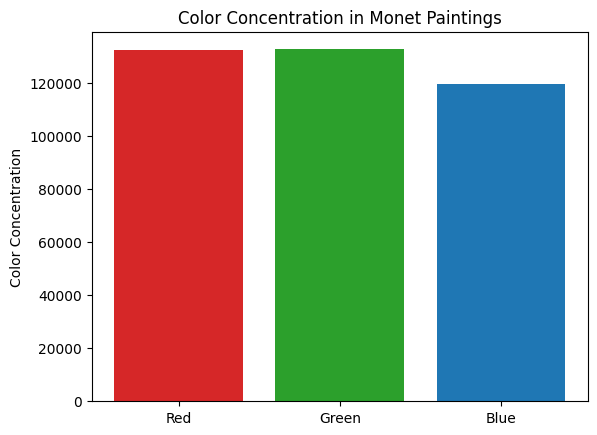

In [6]:
fig, ax = plt.subplots()

Colors = ['Red', 'Green', 'Blue']
counts = [sum(red), sum(green), sum(blue)]
bar_labels = ['red', 'green', 'blue']
bar_colors = ['tab:red', 'tab:green', 'tab:blue']

ax.bar(Colors, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Color Concentration')
ax.set_title('Color Concentration in Monet Paintings')

plt.show()

In [7]:
#make sure there are no duplicates in the photo and painting file names

painting_list = listdir(paintings_directory)
photo_list = listdir(photos_directory)

duplicate_list = []
for photo in photo_list:
    if photo in painting_list:
        duplicate_list.append(photo)
        
print(duplicate_list)

[]


In [8]:
#rescale the painting images
images = []
for file in range(num_paintings):
    images.append(cv2.imread(paintings_directory + listdir(paintings_directory)[file]))

dataset = np.array(images)
dataset = dataset/255

#do the same for the photos
images2 = []
for file in range(num_photos):
    images2.append(cv2.imread(photos_directory + listdir(photos_directory)[file]))

predict_data = np.array(images)
predict_data = dataset/255

#make sure they match!
print("Image list size, ", len(images))
print("Image size, ", images[0].shape)
print("Dataset list size, ", len(dataset))
print("Dataset size, ", dataset[0].shape)

Image list size,  300
Image size,  (256, 256, 3)
Dataset list size,  300
Dataset size,  (256, 256, 3)


<font color="Green"><h2> **Model Architecture (Build the Model)**</h2></font>
<p>
We have the option of using a non-generative model to get Monet-style images (a network which takes in images and returns them in Monet-style) or not (like DCGAN). We will use DCGAN in this project, a modified implimentation of the one from the keras website that was taught in the lecture videos. We adjust the discirminator and generator models to be able to handle our Money images an generate images of the correct size. I tried different strides and paddings but ultimantely the default  one performed the best, suprisingly.  Ultimantely did not use the real photos in our implimentations. As per the competition rules, it was not neccessary. 

In [9]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(8, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(16, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(16, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 8)    │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 16)     │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,953 (89.66 KB)

 Trainable params: 22,953 (89.66 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
latent_dim = 512

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(32 * 32 * 128),
        layers.Reshape((32, 32, 128)),
        layers.Conv2DTranspose(16, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 131072)         │    67,239,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 16)     │        32,784 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 32)   │         8,224 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 32)   │        16,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 3)    │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,299,763 (256.73 MB)

 Trainable params: 67,299,763 (256.73 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(888)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    def train_step(self, real_images):
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(shape=(batch_size, self.latent_dim), seed=self.seed_generator)
        generated_images = self.generator(random_latent_vectors)
        combined_images = ops.concatenate([generated_images, real_images], axis=0)
        labels = ops.concatenate([ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        misleading_labels = ops.zeros((batch_size, 1))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [19]:
#make folder to store our images

os.mkdir("/kaggle/working/images/")

<font color="Green"><h2> **Train the Model**</h2></font>
<p>

In [13]:
#set epochs and compile the model

epochs = 10 #For the Kaggle competition epochs = 100, I set to ten for speed in the notebook submission
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(d_optimizer=keras.optimizers.Adam(learning_rate=0.0001), g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss_fn = keras.losses.BinaryCrossentropy(),)

In [14]:
#fit out model

gan.fit(dataset, epochs = epochs)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 74s 7s/step - d_loss: 0.6865 - g_loss: 0.7140
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 69s 7s/step - d_loss: 0.6439 - g_loss: 0.7663
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 69s 7s/step - d_loss: 0.5847 - g_loss: 0.8577
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 69s 7s/step - d_loss: 0.5160 - g_loss: 0.9713
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 70s 7s/step - d_loss: 0.4634 - g_loss: 1.1495
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 69s 7s/step - d_loss: 0.4111 - g_loss: 1.3651
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 69s 7s/step - d_loss: 0.4258 - g_loss: 1.4589
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 69s 7s/step - d_loss: 0.4477 - g_loss: 1.4778
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 69s 7s/step - d_loss: 0.5063 - g_loss: 1.4767
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 69s 7s/step - d_loss: 0.6288 - g_loss: 1.2703


In [15]:
#a functin to clear the kaggle output folder without resetting the kernel - just for convenience

def clearFolder():
    folder = '/kaggle/working/images.zip'
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

#clearFolder()

In [16]:
#generate 7000 images in our model per the competition rules

batch_size = 70 # used 7000 for the actual kaggle compeititon
random_latent_vectors = keras.random.normal(shape=(batch_size, 512), seed=keras.random.SeedGenerator(1337))
output = gan.generator.predict(random_latent_vectors)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 702ms/step


In [17]:
#save our images

for i in range(batch_size):
    img = keras.utils.array_to_img(output[i])
    img.save("/kaggle/working/images/generated_img_%d.png" % i)

In [18]:
#zip them up

shutil.make_archive("images", 'zip', "/kaggle/working/images")

'/kaggle/working/images.zip'

<font color="Green"><h2> **Conclusion**</h2></font>
<p>Generally speaking our GAN model did not perform the best. I am of the belief that GAN was not the best model for the task but rather an autoendocder would have been better. For the old version of the competition it seemed a DCGAN model would have been ideal, but for the new one something more like an autoencoder mixed with a genereative model might have been better. A paper out of Cornell University (link in reference list) proposed something called a Adversarial AutoencodersAdversarial Autoencoders which would probably have been perfect for this compeition, but I chose to impliment DGSCAN as the assignement required us to use a GAN model. 

<font color="Green"><h2> **Reference List**</h2></font>
<p><a href ="https://arxiv.org/abs/1511.05644https://arxiv.org/abs/1511.05644"> Adversarial Autoencoder Models </a>
<p><a href ="https://keras.io/examples/generative/dcgan_overriding_train_step/https://keras.io/examples/generative/dcgan_overriding_train_step/"> DCGAN Keras Documentation </a>
<p><a href = "https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_colors.htmlhttps://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_colors.html">Matplot documentation </a>
